In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)

In [25]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [26]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [29]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [30]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

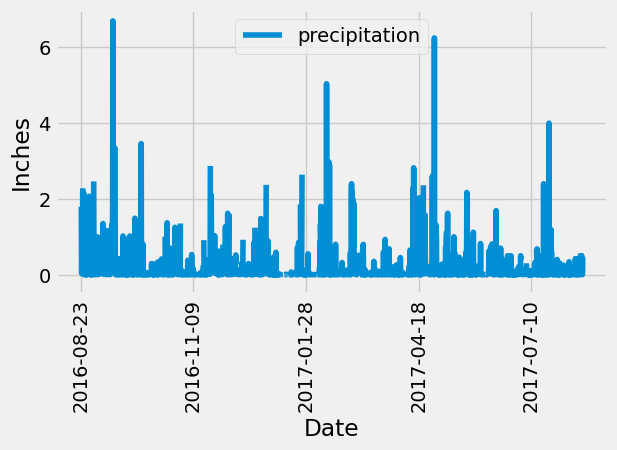

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt
from datetime import datetime
most_recent_date_dt = datetime.strptime(most_recent_date.date, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.

year_ago = most_recent_date_dt - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
values = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
values_df = pd.DataFrame(values)
values_df = values_df.rename(columns={"prcp":"precipitation"})
# Sort the dataframe by date
values_df = values_df.sort_values("date", ascending=True)

values_final_df = values_df.set_index("date")

# Use Pandas Plotting with Matplotlib to plot the data
values_final_df.plot(xlabel="Date", ylabel="Inches",)
plt.ylim(-0.5, 7)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
values_final_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count() 

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0]
most_active_station_id = most_active_station[0]

temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
  filter(Measurement.station == most_active_station_id).all()

print(temperatures) 

[(54.0, 85.0, 71.66378066378067)]


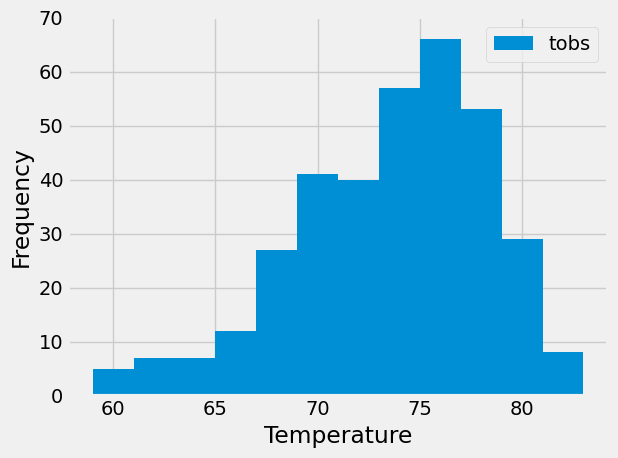

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(Measurement.date).\
    filter(Measurement.station == most_active_station_id).\
    order_by(Measurement.date.desc()).first()


year_ago = most_recent_date_dt - dt.timedelta(days=365)
year_ago

values = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= year_ago).\
    all()

values_df = pd.DataFrame(values)

tobs = values_df["tobs"]
# print(tobs_df)
# tobs_df = tobs_df.rename(columns={"":"tobs"})


histo = tobs.hist(bins = 12,label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.ylim(0, 70)
plt.legend()
plt.tight_layout()

# Close Session

In [18]:
# Close Session
session.close()